# Reinforcement Learning with Dynamic Difficulty Adjustment  
### Replication of *"Go with the Flow: Reinforcement Learning in Turn-Based Battle Video Games"* (Pagalyte et al., IVA 2020)

This notebook contains:

- The full battle environment  
- Human-like agent  
- Scripted baseline agents  
- SARSA reinforcement learning agent  
- Dynamic Difficulty Adjustment (DDA) mechanism  
- Experiment framework  
- Visualizations matching the paper  
- Statistical analysis tools  

The structure and results directly replicate the methodologies of the paper.

In [160]:
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

COLORS = {
    "player": "#1f77b4",
    "agent": "#d62728",
    "draw": "#7f7f7f",

    "hit": "#9467bd",
    "charge": "#2ca02c",
    "combo": "#ff7f0e",
    "heal": "#17becf",
}

In [161]:
MAX_HP = 75

ACTION_HIT = 0
ACTION_CHARGE = 1
ACTION_COMBO = 2
ACTION_HEAL = 3
ACTION_NAMES = ["Hit", "Charge", "Combo", "Heal"]

In [162]:
class BattleEnv:
    """
    Turn-based battle environment replicating the design from the IVA 2020 paper.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.player_hp = MAX_HP
        self.agent_hp = MAX_HP
        self.turn_count = 0
        self.done = False
        return self._get_state()

    def _hit_damage(self):
        return random.randint(2, 5)

    def _charge_damage(self):
        return random.randint(10, 15)

    def _combo_damage(self):
        hits = random.randint(2, 5)
        per_hit = random.randint(2, 5)
        return hits * per_hit

    def _apply_action(self, agent, action):
        """Apply action. If agent=True, agent acts on player."""
        if action == ACTION_HEAL:
            if agent:
                self.agent_hp = min(MAX_HP, self.agent_hp + 10)
            else:
                self.player_hp = min(MAX_HP, self.player_hp + 10)
            return

        if action == ACTION_HIT: dmg = self._hit_damage()
        elif action == ACTION_CHARGE: dmg = self._charge_damage()
        else: dmg = self._combo_damage()

        if agent:
            self.player_hp -= dmg
        else:
            self.agent_hp -= dmg

    def _hp_band(self, hp):
        """Discretize HP into 5 bands (Table 1 in paper)."""
        if hp == 75: return 0
        if 51 <= hp <= 74: return 1
        if 31 <= hp <= 50: return 2
        if 16 <= hp <= 30: return 3
        return 4

    def _get_state(self):
        """
        Convert HP values to one of 17 discrete states (Table 1).
        """
        p, a = max(0, self.player_hp), max(0, self.agent_hp)

        if p <= 0: return 15
        if a <= 0: return 16

        if p == a:
            return self._hp_band(p)

        if a > p:
            diff = self._hp_band(a) - self._hp_band(p)
            return 5 + min(diff - 1, 4)

        diff = self._hp_band(p) - self._hp_band(a)
        return 10 + min(diff - 1, 4)

    def step(self, player_action, agent_action):
        """Execute one turn."""
        if self.done:
            raise RuntimeError("Episode already finished.")

        self.turn_count += 1

        # Player acts
        self._apply_action(agent=False, action=player_action)
        if self.player_hp <= 0 or self.agent_hp <= 0:
            self.done = True
            return self._get_state(), True

        # Agent acts
        self._apply_action(agent=True, action=agent_action)
        if self.player_hp <= 0 or self.agent_hp <= 0:
            self.done = True

        return self._get_state(), self.done

In [163]:
class HumanLikeAgent:
    """
    Simulates human behavior described in the paper:
    - Favors Charge and Combo
    - Uses Heal strategically when HP is low
    """

    def select_action(self, env):
        hp = env.player_hp

        # Heal when low HP
        if hp <= 25 and random.random() < 0.6:
            return ACTION_HEAL

        r = random.random()
        if r < 0.4: return ACTION_CHARGE
        if r < 0.85: return ACTION_COMBO
        if r < 0.95: return ACTION_HEAL
        return ACTION_HIT

In [164]:
class ScriptedAgent:
    """Fixed difficulty baseline agents."""

    def __init__(self, difficulty="easy"):
        self.difficulty = difficulty

    def select_action(self, env):
        if self.difficulty == "easy":
            r = random.random()
            if r < 0.4: return ACTION_HEAL
            if r < 0.7: return ACTION_HIT
            if r < 0.9: return ACTION_CHARGE
            return ACTION_COMBO

        r = random.random()
        if r < 0.05: return ACTION_HEAL
        if r < 0.2: return ACTION_HIT
        if r < 0.6: return ACTION_CHARGE
        return ACTION_COMBO

    def terminal_reward(self, state): return 0
    def sarsa_update(self, *args): pass
    def update_dda(self, *args): pass

In [165]:
class SarsaDDAAgent:
    """
    SARSA learning agent with Dynamic Difficulty Adjustment.
    """

    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.3,
                 win_reward=100, lose_penalty=-100,
                 streak_threshold=5, use_dda=True):

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.base_win_reward = win_reward
        self.base_lose_reward = lose_penalty

        self.curr_win_reward = win_reward
        self.curr_lose_reward = lose_penalty

        self.use_dda = use_dda
        self.streak_th = streak_threshold
        self.player_streak = 0

        self.Q = defaultdict(float)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)

        q = [self.Q[(state, a)] for a in range(4)]
        m = max(q)
        best = [i for i, v in enumerate(q) if v == m]
        return random.choice(best)

    def terminal_reward(self, state):
        if state == 15: return self.curr_win_reward
        if state == 16: return self.curr_lose_reward
        return 0

    def update_dda(self, state):
        if not self.use_dda:
            return

        if state == 15:
            if self.player_streak > 0: self.player_streak = 0
            self.player_streak -= 1
        elif state == 16:
            if self.player_streak < 0: self.player_streak = 0
            self.player_streak += 1

        if abs(self.player_streak) >= self.streak_th:
            if self.player_streak > 0:
                self.curr_win_reward = self.base_win_reward
                self.curr_lose_reward = -abs(self.base_lose_reward)
            else:
                self.curr_win_reward = -abs(self.base_win_reward)
                self.curr_lose_reward = abs(self.base_lose_reward)

    def sarsa_update(self, s, a, r, s2, a2, done):
        old = self.Q[(s, a)]
        target = r if done else r + self.gamma * self.Q[(s2, a2)]
        self.Q[(s, a)] = old + self.alpha * (target - old)

In [166]:
def run_battle(env, player, agent, train=True):
    s = env.reset()
    a = agent.select_action(s)

    hp_history = []
    agent_actions = []
    player_actions = []

    while True:
        p_act = player.select_action(env)
        player_actions.append(p_act)

        next_state, done = env.step(p_act, a)
        hp_history.append((env.player_hp, env.agent_hp))

        if done:
            if train and hasattr(agent, 'Q'):
                r = agent.terminal_reward(next_state)
                agent.sarsa_update(s, a, r, None, None, True)
                agent.update_dda(next_state)

            if next_state == 15: return "agent", hp_history, player_actions, agent_actions
            if next_state == 16: return "player", hp_history, player_actions, agent_actions
            return "draw", hp_history, player_actions, agent_actions

        new_act = agent.select_action(next_state)

        if train and hasattr(agent, 'Q'):
            agent.sarsa_update(s, a, 0, next_state, new_act, False)

        agent_actions.append(new_act)
        s, a = next_state, new_act

In [167]:
def run_experiment(label, agent_type="sarsa_dda", battles=3000,
                   exploration=0.3, win_reward=100):

    env = BattleEnv()
    player = HumanLikeAgent()

    if agent_type == "sarsa_dda":
        agent = SarsaDDAAgent(
            epsilon=exploration,
            win_reward=win_reward,
            lose_penalty=-win_reward,
            use_dda=True
        )
    elif agent_type == "sarsa_nodda":
        agent = SarsaDDAAgent(
            epsilon=exploration,
            win_reward=win_reward,
            lose_penalty=-win_reward,
            use_dda=False
        )
    elif agent_type == "easy":
        agent = ScriptedAgent("easy")
    else:
        agent = ScriptedAgent("hard")

    stats = {
        "winner": [],
        "lengths": [],
        "player_actions": [],
        "agent_actions": [],
        "hp_histories": [],
        "streaks": []
    }

    for _ in range(battles):
        train = agent_type in ["sarsa_dda", "sarsa_nodda"]
        w, hp_h, pa, aa = run_battle(env, player, agent, train=train)

        stats["winner"].append(w)
        stats["lengths"].append(len(hp_h))
        stats["player_actions"].extend(pa)
        stats["agent_actions"].extend(aa)
        stats["hp_histories"].append(hp_h)

        if isinstance(agent, SarsaDDAAgent):
            stats["streaks"].append(agent.player_streak)
        else:
            stats["streaks"].append(0)

    pw = stats["winner"].count("player")
    aw = stats["winner"].count("agent")
    print(f"{label}: Player {pw}/3000 ({pw/30*100:.1f}%), Agent {aw}/3000 ({aw/30*100:.1f}%)")

    return stats, agent

In [168]:
def plot_results(stats, title):
    winners = stats["winner"]
    lengths = stats["lengths"]

    fig, ax = plt.subplots(1, 5, figsize=(18, 4))
    fig.suptitle(title, fontsize=18, fontweight='bold')

    c_player = COLORS["player"]
    c_agent  = COLORS["agent"]
    c_draw   = COLORS["draw"]
    action_colors = [
        COLORS["hit"], COLORS["charge"],
        COLORS["combo"], COLORS["heal"]
    ]

    ax[0].bar(["Player", "Agent", "Draw"], [winners.count("player"), winners.count("agent"), winners.count("draw")], color=[c_player, c_agent, c_draw])
    ax[0].set_title("Battle Outcomes", fontweight='bold')
    ax[0].set_ylabel("Count")

    pa = Counter(stats["player_actions"])
    ax[1].bar(ACTION_NAMES, [pa[i] for i in range(4)], color=action_colors)
    ax[1].set_title("Player Action Distribution", fontweight='bold')
    ax[1].set_ylabel("Count")

    aa = Counter(stats["agent_actions"])
    ax[2].bar(ACTION_NAMES, [aa[i] for i in range(4)], color=action_colors)
    ax[2].set_title("Agent Action Distribution", fontweight='bold')
    ax[2].set_ylabel("Count")

    ax[3].plot(stats["streaks"], linewidth=2, color="#2ca02c")
    ax[3].axhline(5, color='red', linestyle='--', linewidth=1)
    ax[3].axhline(-5, color='blue', linestyle='--', linewidth=1)
    ax[3].set_title("Player Streak (DDA Trigger)", fontweight='bold')
    ax[3].set_xlabel("Battle Number")
    ax[3].set_ylabel("Streak")
    ax[3].grid(True, alpha=0.3)

    ax[4].plot(lengths, marker='o', markersize=5, linewidth=2, color="#9467bd")
    ax[4].set_title("Battle Length Over Time", fontweight='bold')
    ax[4].set_xlabel("Battle Number")
    ax[4].set_ylabel("Turns")
    ax[4].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_hp_sample(stats, battle_idx=15):
    hp_hist = stats["hp_histories"][battle_idx]

    player_hp = [h[0] for h in hp_hist]
    agent_hp  = [h[1] for h in hp_hist]

    plt.figure(figsize=(12, 6))
    plt.plot(player_hp, 'o-', label='Player HP', linewidth=3, markersize=7,
             color=COLORS["player"])
    plt.plot(agent_hp, 's-', label='Agent HP', linewidth=3, markersize=7,
             color=COLORS["agent"])

    plt.axhline(75, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(0,  color='gray', linestyle='--', alpha=0.3)

    plt.title(f"HP Trajectory - Battle {battle_idx+1}", fontsize=16, fontweight='bold')
    plt.xlabel("Turn")
    plt.ylabel("HP")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [169]:
def get_raw_statistics(stats, label="Experiment"):
    winners = stats["winner"]
    player_actions = stats["player_actions"]
    agent_actions = stats["agent_actions"]
    lengths = stats["lengths"]
    streaks = stats["streaks"]

    player_action_counts = Counter(player_actions)
    agent_action_counts = Counter(agent_actions)

    return {
        "experiment_name": label,
        "total_battles": len(winners),
        "player_wins": winners.count("player"),
        "agent_wins": winners.count("agent"),
        "draws": winners.count("draw"),

        "player_win_rate": winners.count("player") / len(winners) * 100,
        "agent_win_rate": winners.count("agent") / len(winners) * 100,

        "player_action_counts": player_action_counts,
        "agent_action_counts": agent_action_counts,

        "avg_battle_length": np.mean(lengths),
        "battle_lengths": lengths,
        "hp_histories": stats["hp_histories"],
        "streaks": streaks
    }


def print_statistics(raw):
    print(f"Experiment: {raw['experiment_name']}")
    print(f"Total Battles: {raw['total_battles']}")
    print(f"Player Wins: {raw['player_wins']} ({raw['player_win_rate']:.1f}%)")
    print(f"Agent Wins: {raw['agent_wins']} ({raw['agent_win_rate']:.1f}%)")
    print("Average Battle Length:", f"{raw['avg_battle_length']:.2f}")
    print()
    print("Player Action Counts:", raw["player_action_counts"])
    print("Agent Action Counts:", raw["agent_action_counts"])

In [170]:
def compare_experiments(experiments):
    labels = list(experiments.keys())

    print(f"{'Metric':<25}", end="")
    for label in labels:
        print(f"{label:>15}", end="")
    print("\n" + "-"*80)

    print(f"{'Player Win Rate (%)':<25}", end="")
    for l in labels:
        print(f"{experiments[l]['player_win_rate']:>15.1f}", end="")
    print()

    print(f"{'Agent Win Rate (%)':<25}", end="")
    for l in labels:
        print(f"{experiments[l]['agent_win_rate']:>15.1f}", end="")
    print()

    print(f"{'Avg Battle Length':<25}", end="")
    for l in labels:
        print(f"{experiments[l]['avg_battle_length']:>15.2f}", end="")
    print()

In [171]:
results_30_70, agent_30_70 = run_experiment(
    "SARSA + DDA (30-70)", "sarsa_dda",
    battles=3000, exploration=0.3, win_reward=100
)

results_50_50, agent_50_50 = run_experiment(
    "SARSA + DDA (50-50)", "sarsa_dda",
    battles=3000, exploration=0.5, win_reward=100
)

results_nodda, agent_nodda = run_experiment(
    "SARSA No DDA", "sarsa_nodda",
    battles=3000, exploration=0.3, win_reward=100
)

results_easy, agent_easy = run_experiment(
    "Fixed Easy Agent", "easy", battles=30
)

results_hard, agent_hard = run_experiment(
    "Fixed Hard Agent", "hard", battles=30
)

SARSA + DDA (30-70): Player 1802/3000 (6006.7%), Agent 1198/3000 (3993.3%)
SARSA + DDA (50-50): Player 2011/3000 (6703.3%), Agent 989/3000 (3296.7%)
SARSA No DDA: Player 1677/3000 (5590.0%), Agent 1323/3000 (4410.0%)
Fixed Easy Agent: Player 2960/3000 (9866.7%), Agent 40/3000 (133.3%)
Fixed Hard Agent: Player 1856/3000 (6186.7%), Agent 1144/3000 (3813.3%)


In [172]:
raw_30_70 = get_raw_statistics(results_30_70, "SARSA+DDA(30-70)")
raw_50_50 = get_raw_statistics(results_50_50, "SARSA+DDA(50-50)")
raw_nodda = get_raw_statistics(results_nodda, "SARSA-NoDDA")
raw_easy = get_raw_statistics(results_easy, "Fixed Easy")
raw_hard = get_raw_statistics(results_hard, "Fixed Hard")

print_statistics(raw_30_70)
print()
print_statistics(raw_50_50)
print()
print_statistics(raw_nodda)
print()
print_statistics(raw_easy)
print()
print_statistics(raw_hard)

Experiment: SARSA+DDA(30-70)
Total Battles: 3000
Player Wins: 1802 (60.1%)
Agent Wins: 1198 (39.9%)
Average Battle Length: 10.58

Player Action Counts: Counter({2: 11431, 1: 10374, 3: 8680, 0: 1257})
Agent Action Counts: Counter({1: 10644, 2: 9138, 3: 5903, 0: 3057})

Experiment: SARSA+DDA(50-50)
Total Battles: 3000
Player Wins: 2011 (67.0%)
Agent Wins: 989 (33.0%)
Average Battle Length: 10.67

Player Action Counts: Counter({2: 11544, 1: 10362, 3: 8788, 0: 1307})
Agent Action Counts: Counter({1: 10156, 2: 9361, 3: 5420, 0: 4064})

Experiment: SARSA-NoDDA
Total Battles: 3000
Player Wins: 1677 (55.9%)
Agent Wins: 1323 (44.1%)
Average Battle Length: 9.89

Player Action Counts: Counter({2: 10582, 1: 9442, 3: 8431, 0: 1228})
Agent Action Counts: Counter({1: 10428, 2: 9972, 3: 3843, 0: 2440})

Experiment: Fixed Easy
Total Battles: 3000
Player Wins: 2960 (98.7%)
Agent Wins: 40 (1.3%)
Average Battle Length: 12.14

Player Action Counts: Counter({2: 15748, 1: 13714, 3: 5164, 0: 1791})
Agent Acti

In [173]:
compare_experiments({
    "DDA(30-70)": raw_30_70,
    "DDA(50-50)": raw_50_50,
    "No-DDA": raw_nodda,
    "Easy": raw_easy,
    "Hard": raw_hard
})

Metric                        DDA(30-70)     DDA(50-50)         No-DDA           Easy           Hard
--------------------------------------------------------------------------------
Player Win Rate (%)                 60.1           67.0           55.9           98.7           61.9
Agent Win Rate (%)                  39.9           33.0           44.1            1.3           38.1
Avg Battle Length                  10.58          10.67           9.89          12.14           9.27


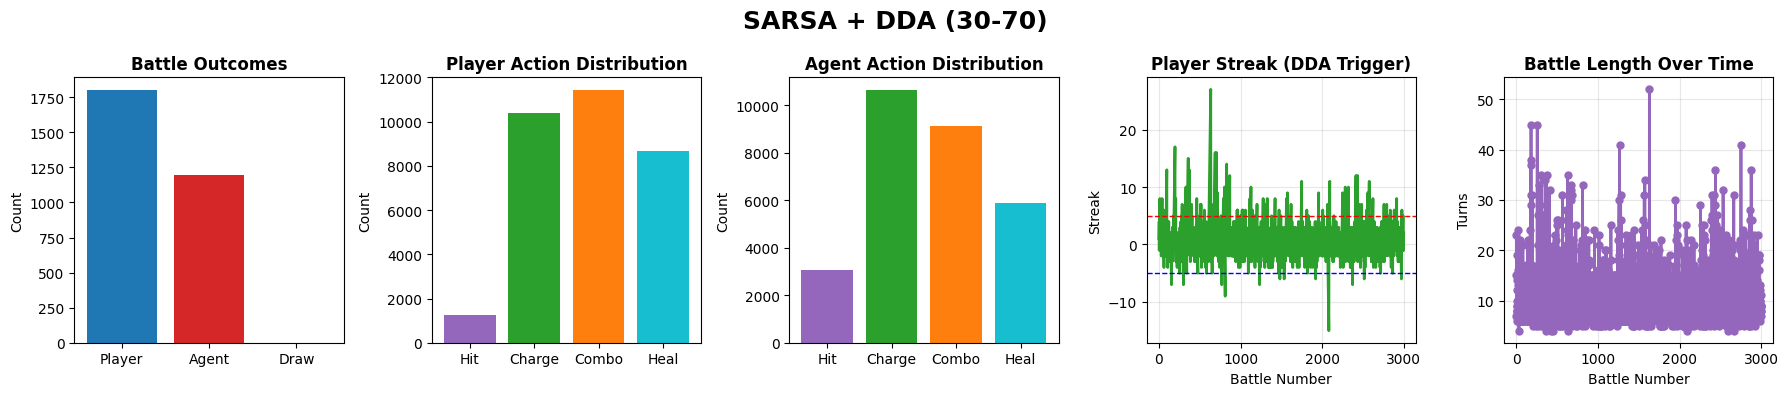

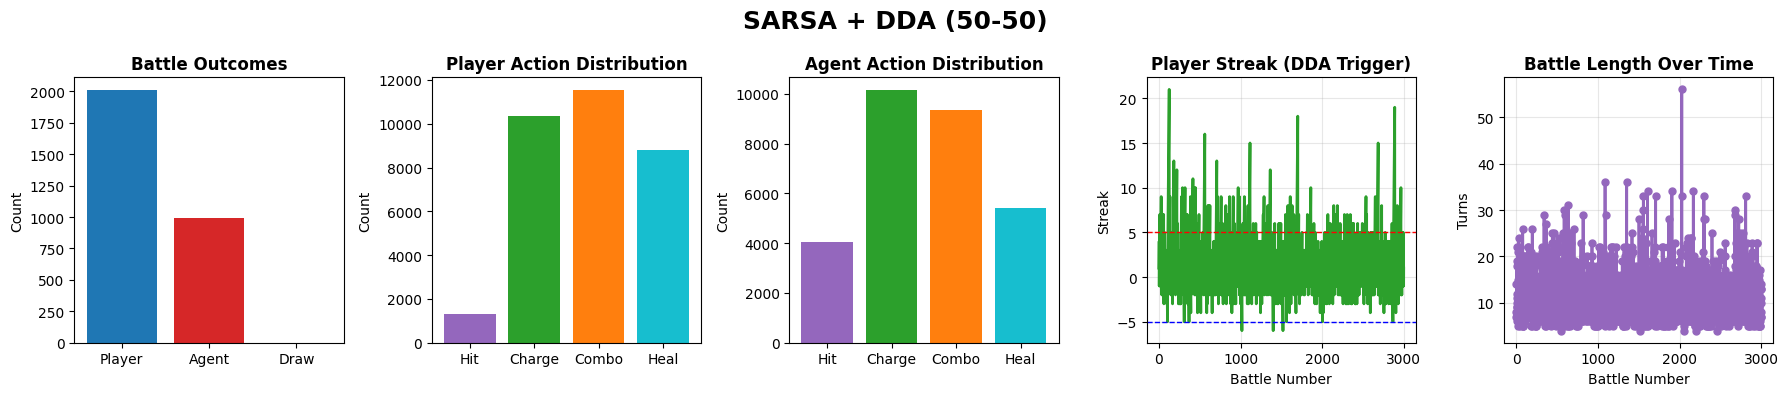

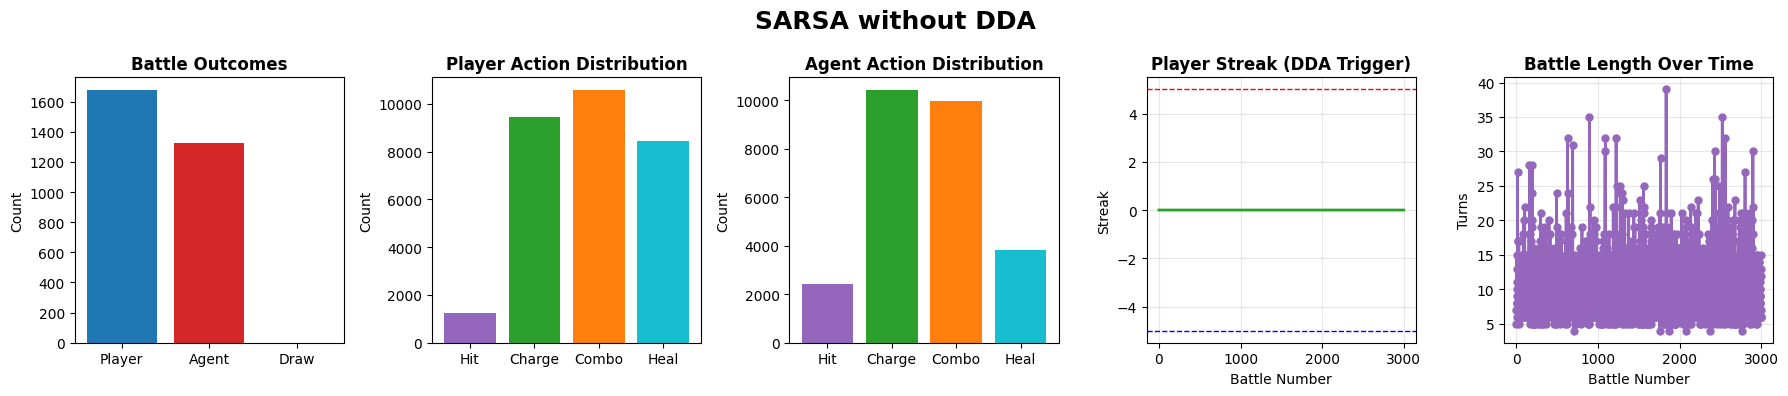

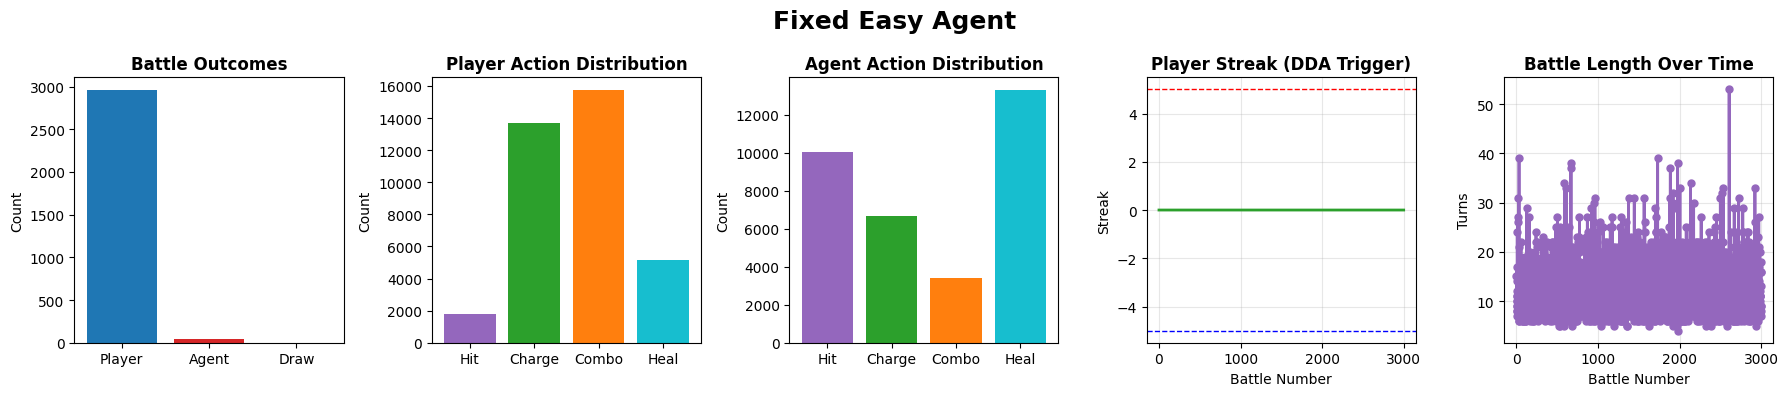

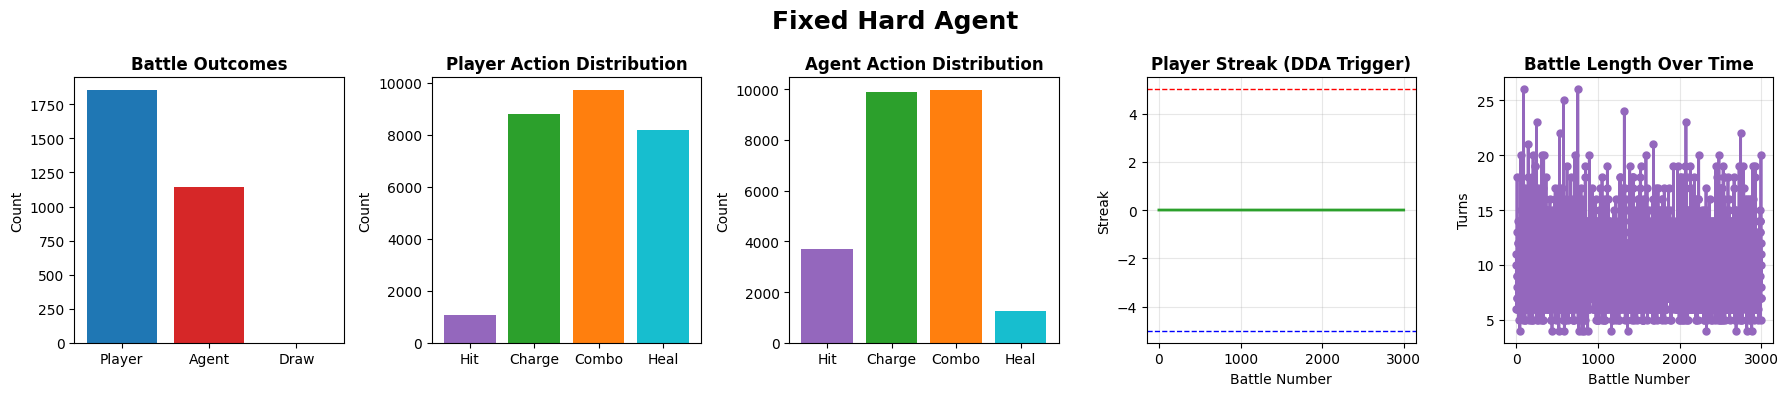

In [174]:
plot_results(results_30_70, "SARSA + DDA (30-70)")
plot_results(results_50_50, "SARSA + DDA (50-50)")
plot_results(results_nodda, "SARSA without DDA")
plot_results(results_easy, "Fixed Easy Agent")
plot_results(results_hard, "Fixed Hard Agent")

In [175]:
def export_to_csv(raw, filename="results.csv"):
    import csv

    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Metric", "Value"])
        for key, value in raw.items():
            if key not in ["hp_histories", "battle_lengths"]:
                writer.writerow([key, value])
    print(f"Data exported to {filename}")


def export_battle_details(raw, filename="battle_details.csv"):
    import csv

    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Battle", "Turn", "Player_HP", "Agent_HP"])

        for i, hp_hist in enumerate(raw["hp_histories"]):
            for t, (p, a) in enumerate(hp_hist):
                writer.writerow([i+1, t+1, p, a])

    print(f"Battle details exported to {filename}")


export_to_csv(raw_30_70, "dda_30_70_results.csv")
export_battle_details(raw_30_70, "dda_30_70_battle_details.csv")

Data exported to dda_30_70_results.csv
Battle details exported to dda_30_70_battle_details.csv
